In [ ]:
# pyright: reportUnusedExpression=false

In [ ]:
# Importando bibliotecas
from tqdm import tqdm
import numpy as np
import pandas as pd
import socceraction.spadl as spd
from socceraction import xthreat as xt

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

# [CDAF] Atividade 4

## Nome e matrícula
Nome: Igor Lacerda Faria da Silva
Matrícula: 2020041973

### LaLiga  p/ SPADL com pré-processamentos

In [ ]:
DATA_FOLDER = "data"

In [ ]:
# Para o depurador...
# DATA_FOLDER = "../data/"

In [ ]:
COUNTRY = "Spain"

In [ ]:
# carregando os eventos
# path = r"C:\Users\Galo\Hugo_Personal\Data\Wyscout_Top_5\events\events_Spain.json"
path = f"{DATA_FOLDER}/events/events_{COUNTRY}.json"
events = pd.read_json(path_or_buf=path)

In [ ]:
# pré processamento em colunas da tabela de eventos para facilitar a conversão p/ SPADL
events = events.rename(
    columns={
        "id": "event_id",
        "eventId": "type_id",
        "subEventId": "subtype_id",
        "teamId": "team_id",
        "playerId": "player_id",
        "matchId": "game_id",
    }
)
events["milliseconds"] = events["eventSec"] * 1000
events["period_id"] = events["matchPeriod"].replace({"1H": 1, "2H": 2})

In [ ]:
# carregando as partidas, pois vamos saber quais times jogam em casa e fora p/ usar como parametro do SPADL
# path = r"C:\Users\Galo\Hugo_Personal\Data\Wyscout_Top_5\matches\matches_Spain.json"
path = f"{DATA_FOLDER}/matches/matches_{COUNTRY}.json"
matches = pd.read_json(path_or_buf=path)

In [ ]:
# as informações dos times de cada partida estão em um dicionário dentro da coluna 'teamsData', então vamos separar essas informações
team_matches = []
for i in tqdm(range(len(matches))):
    teams_data = matches.loc[i, "teamsData"]
    if isinstance(teams_data, dict):  # check if teams_data is a dictionary-like object
        match = pd.DataFrame(teams_data).T
        match["matchId"] = matches.loc[i, "wyId"]
        team_matches.append(match)
    else:
        # handle the case where teams_data is not a dictionary-like object
        print(f"teamsData for match {matches.loc[i, 'match_id']} is not a dictionary.")
team_matches = pd.concat(team_matches).reset_index(drop=True)

In [ ]:
# fazendo a conversão p/ SPADL, padronizando a direção de jogo da esquerda p/ a direita e adicionando os nomes dos tipos de ações
actions = []
game_ids = events.game_id.unique().tolist()
for g in tqdm(game_ids):
    match_events = events.loc[events.game_id == g]
    match_home_id = team_matches.query(f"matchId == {g} and side == 'home'")[
        "teamId"
    ].values[0]
    match_actions = spd.wyscout.convert_to_actions(
        events=match_events, home_team_id=match_home_id
    )
    match_actions = spd.play_left_to_right(
        actions=match_actions, home_team_id=match_home_id
    )
    match_actions = spd.add_names(match_actions)
    actions.append(match_actions)
spadl = pd.concat(actions).reset_index(drop=True)

In [ ]:
# adicionando o nome dos jogadores
# path = r"C:\Users\Galo\Hugo_Personal\Data\Wyscout_Top_5\players.json"
path = f"{DATA_FOLDER}/players/players.json"
players = pd.read_json(path_or_buf=path)
players["player_name"] = players["shortName"].apply(
    lambda x: x.encode("utf-8").decode("unicode-escape")  # conserte as strings
)
players = players[["wyId", "player_name"]].rename(columns={"wyId": "player_id"})
spadl = spadl.merge(players, on="player_id", how="left")

## Questão 1
- Crie um dataframe "shots" à partir do dataframe "spadl", contendo apenas os chutes.
- Crie 4 colunas no dataframe "shots" a serem usadas como features de um modelo de xG.
- Justifique a escolha das features.

In [1]:
spadl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 473894 entries, 0 to 473893
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   game_id            473894 non-null  int64  
 1   period_id          473894 non-null  int64  
 2   time_seconds       473894 non-null  float64
 3   team_id            473894 non-null  int64  
 4   player_id          473894 non-null  int64  
 5   start_x            473894 non-null  float64
 6   start_y            473894 non-null  float64
 7   end_x              473894 non-null  float64
 8   end_y              473894 non-null  float64
 9   original_event_id  441653 non-null  object 
 10  bodypart_id        473894 non-null  int64  
 11  type_id            473894 non-null  int64  
 12  result_id          473894 non-null  int64  
 13  action_id          473894 non-null  int64  
 14  type_name          473894 non-null  object 
 15  result_name        473894 non-null  object 
 16  bo

In [2]:
types_of_shot = ["shot", "shot_freekick", "shot_penalty"]
df_shots: pd.DataFrame = spadl.query("type_name in @types_of_shot")
df_shots

        game_id  period_id  time_seconds  ...  result_name  bodypart_name        player_name
20      2565548          1     57.771186  ...         fail           foot  José Luis Morales
22      2565548          1     60.727239  ...         fail           foot           J. Lerma
93      2565548          1    446.986112  ...         fail           foot           C. Bacca
96      2565548          1    488.929113  ...         fail           foot        A. Rukavina
178     2565548          1    948.872079  ...         fail           foot  José Luis Morales
...         ...        ...           ...  ...          ...            ...                ...
473673  2565927          2   1944.188119  ...         fail           foot        R. Martínez
473806  2565927          2   2385.837008  ...      success           foot    Samu Castillejo
473828  2565927          2   2672.823612  ...         fail           foot    Samu Castillejo
473851  2565927          2   2722.835144  ...         fail           f

In [ ]:
GOAL_CENTER_X: int = 105
GOAL_CENTER_Y: int = 34

UPPER_CROSSBAR_X: int = 105
UPPER_CROSSBAR_Y: int = 38

LOWER_CROSSBAR_X: int = 105
LOWER_CROSSBAR_Y: int = 30

In [ ]:
df_shots["shot_distance"] = np.sqrt(
    (df_shots["start_x"] - GOAL_CENTER_X) ** 2
    + (df_shots["start_y"] - GOAL_CENTER_Y) ** 2
)

In [ ]:
def get_shot_angle(shot_pos_x, shot_pos_y):
    u = np.array([UPPER_CROSSBAR_X - shot_pos_x, UPPER_CROSSBAR_Y - shot_pos_y])
    v = np.array([LOWER_CROSSBAR_X - shot_pos_x, LOWER_CROSSBAR_Y - shot_pos_y])
    return np.arccos(np.dot(u / np.linalg.norm(u), v / np.linalg.norm(v)))


df_shots["shot_angle"] = df_shots[["start_x", "start_y"]].apply(
    lambda pos: get_shot_angle(pos["start_x"], pos["start_y"]), axis=1
)

In [ ]:
df_shots["distance_x_angle"] = df_shots["shot_angle"] * df_shots["shot_distance"]

In [ ]:
df_shots["bodypart_weight"] = df_shots["bodypart_name"].apply(
    lambda x: 1 if x == "foot" else 0.3
)

In [3]:
df_shots.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8545 entries, 20 to 473878
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   game_id            8545 non-null   int64  
 1   period_id          8545 non-null   int64  
 2   time_seconds       8545 non-null   float64
 3   team_id            8545 non-null   int64  
 4   player_id          8545 non-null   int64  
 5   start_x            8545 non-null   float64
 6   start_y            8545 non-null   float64
 7   end_x              8545 non-null   float64
 8   end_y              8545 non-null   float64
 9   original_event_id  8545 non-null   object 
 10  bodypart_id        8545 non-null   int64  
 11  type_id            8545 non-null   int64  
 12  result_id          8545 non-null   int64  
 13  action_id          8545 non-null   int64  
 14  type_name          8545 non-null   object 
 15  result_name        8545 non-null   object 
 16  bodypart_name      85

### Escolhas

- Distância: um candidato óbvio, pois é muito mais fácil acertar chutes de perto.

- Ângulo: outro parâmetro clássico, sem muito o que falar. 

- `distance_x_angle`: aumentando o peso dos parâmetros tradicionais, peguei mais porque o Meira comentou em uma das aulas.

- `bodypart_weight`: pra fechar o time com chave de ouro, é reduzido o peso de partes do corpo que não são os pés, porque, presumivelmente, é mais difífil fazer gol com outras partes.

## Questão 2
- Crie uma coluna numérica binária "goal" no dataframe "shots" indicando se o chute resultou em gol ou não.
- Use regressão logística p/ treinar (.fit(X_train, y_train)) um modelo de xG usando as features criadas na questão 1.
- Use 70% dos dados para treino e 30% para teste.
- Reporte a acurácia do modelo para os conjuntos de treino (.score(X_train, y_train)) e teste (.score(X_test, y_test)).

In [ ]:
# Não é necessário criar uma coluna nova, basta usar a coluna de result_id

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    df_shots[["shot_distance", "shot_angle", "distance_x_angle", "bodypart_weight"]],
    df_shots["result_id"],
    test_size=0.3,
)

In [4]:
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [5]:
y_train_acc = model.score(x_train, y_train)
y_test_acc = model.score(x_test, y_test)

print(f"Acurácia nos dados de treino: {y_train_acc}")
print(f"Acurácia nos dados de teste: {y_test_acc}")

Acurácia nos dados de treino: 0.8891489717438555
Acurácia nos dados de teste: 0.8833853354134166


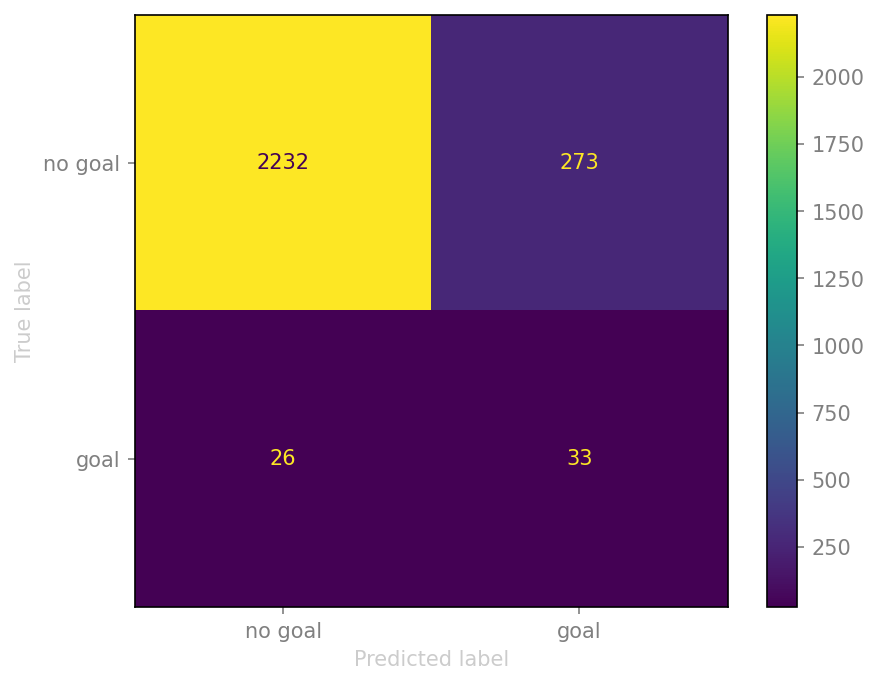

In [6]:
y_pred = model.predict(x_test)
cm = metrics.confusion_matrix(y_pred, y_test)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["no goal", "goal"]
)
cm_display.plot()

## Questão 3
- Use o modelo treinado na questão 2 p/ prever a probabilidade de gol de todos os chutes do dataframe "shots". Reporte essas probabilidades no dataframe "shots" em uma coluna "xG".
- Agrupe o dataframe "shots" por "player_name" e reporte a soma dos "goal" e "xG".
- Reporte os 10 jogadores com maior xG.
- Reporte os 10 jogadores com maior diferença de Gols e xG.

In [7]:
probabilities = model.predict_proba(
    df_shots[["shot_distance", "shot_angle", "distance_x_angle", "bodypart_weight"]]
)
df_shots["xG"] = probabilities[:, 1]
df_shots["xG"]

20        0.112814
22        0.062298
93        0.180006
96        0.086693
178       0.033179
            ...   
473673    0.086017
473806    0.044325
473828    0.021580
473851    0.043409
473878    0.180006
Name: xG, Length: 8545, dtype: float64

In [8]:
columns = ["result_id", "xG"]
shots_by_player = df_shots.groupby(["player_name"])[columns].sum()
shots_by_player

                result_id        xG
player_name                        
A. Aquilani             0  0.769327
A. Arribas              0  0.077680
A. Fernández            0  0.026776
A. Griezmann           19  9.123515
A. Guardado             2  2.043292
...                   ...       ...
Íñigo Martínez          1  2.153181
Ó. Duarte               0  1.470785
Óscar Melendo           0  0.758344
Óscar Romero            0  0.163217
Š. Vrsaljko             0  0.422765

[452 rows x 2 columns]

In [9]:
shots_by_player.sort_values("xG", ascending=False).head(10)

                   result_id         xG
player_name                            
Cristiano Ronaldo         26  26.071219
L. Messi                  34  22.064910
L. Suárez                 25  21.950556
Gerard Moreno             16  15.967054
Iago Aspas                22  14.729205
Maxi Gómez                18  14.320457
C. Stuani                 21  13.285273
C. Bacca                  15  11.026409
J. Calleri                 9  10.849497
Jorge Molina               7  10.689162

In [ ]:
shots_by_player["diff"] = shots_by_player["result_id"] - shots_by_player["xG"]

In [10]:
shots_by_player.sort_values("diff", ascending=False)[columns].head(10)

                 result_id         xG
player_name                          
L. Messi                34  22.064910
A. Griezmann            19   9.123515
C. Stuani               21  13.285273
Iago Aspas              22  14.729205
E. Bardhi                9   2.232741
G. Bale                 16   9.794341
Rodrigo                 16  10.674823
Mikel Oyarzabal         12   6.823400
A. Sanabria              8   3.333896
Ángel                   13   8.423913

## Questão 4
- Instancie um objeto ExpectedThreat com parâmetros l=25 e w=16.
- Faça o fit do modelo ExpectedThreat com o dataframe "spadl".

In [11]:
xT = xt.ExpectedThreat(l=25, w=16)
step = 5000
acc_xT = np.zeros((16, 25))
for i in range(0, len(spadl), step):
    xT.fit(spadl[i : i + step])
    acc_xT += xT.xT

# iterations:  1
# iterations:  1
# iterations:  1
# iterations:  1
# iterations:  17
# iterations:  19
# iterations:  1
# iterations:  1
# iterations:  20
# iterations:  23
# iterations:  1
# iterations:  1
# iterations:  19
# iterations:  19
# iterations:  19
# iterations:  2
# iterations:  1
# iterations:  1
# iterations:  1
# iterations:  19
# iterations:  1
# iterations:  31
# iterations:  1
# iterations:  1
# iterations:  2
# iterations:  1
# iterations:  1
# iterations:  23
# iterations:  2
# iterations:  1
# iterations:  2
# iterations:  20
# iterations:  2
# iterations:  1
# iterations:  1
# iterations:  1
# iterations:  2
# iterations:  22
# iterations:  1
# iterations:  22
# iterations:  1
# iterations:  1
# iterations:  3
# iterations:  1
# iterations:  1
# iterations:  3
# iterations:  1
# iterations:  2
# iterations:  1
# iterations:  20
# iterations:  22
# iterations:  2
# iterations:  1
# iterations:  1
# iterations:  18
# iterations:  2
# iterations:  1
# iterations:  

## Questão 5
- Crie um dataframe "prog_actions" à partir do dataframe "spadl", contendo apenas as ações de progressão e que são bem-sucedidas.
- Use o método rate do objeto ExpectedThreat p/ calcular o valor de cada ação de progressão do dataframe "prog_actions", em uma coluna chamada "action_value".
- Agrupe o dataframe "prog_actions" por "player_name" e reporte a soma dos "action_value".
- Reporte os 10 jogadores com maior "action_value".

In [ ]:
prog_actions = xt.get_successful_move_actions(spadl)
xT.xT = acc_xT
prog_actions["action_value"] = xT.rate(prog_actions)

In [ ]:
action_value = prog_actions.groupby("player_name")["action_value"].sum()

In [12]:
action_value.nlargest(n=10)

player_name
José Luis Morales    97.141770
Portu                90.276712
L. Messi             90.226312
Lucas Vázquez        81.393274
Isco                 71.801897
Marcelo              68.236663
P. Sisto             65.979041
Gonçalo Guedes       64.054006
A. Guardado          61.597146
José Gayá            61.447502
Name: action_value, dtype: float64